In [6]:
import pandas as pd

In [62]:
pd.set_option('display.max_rows', 500)

In [67]:
!ls ../results/round_metrics/*True*

../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.001__Adam_0.0001_SGD_0.001.csv
../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.0023__SGD_0.33_0.9_SGD_0.001.csv
../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.0024__SGD_1_SGD_0.001.csv


In [70]:
best = {
    'FedAdam': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_1000_Adam_0.0001_SGD_0.001.csv',
    'FedAvg': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_1000_SGD_1.0_SGD_0.001.csv',
    'FedAvgM': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_1000_SGDM_0.33_0.9_SGD_0.001.csv',
    'FedAdamW': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_1000_AdamW_0.0001_0.01_SGD_0.001.csv',
    'FedAdagrad': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_1000_Adagrad_0.0001_SGD_0.001.csv',
    
    'FDA-Adam': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.001__Adam_0.0001_SGD_0.001.csv',
    'FDA-SGD': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.0024__SGD_1_SGD_0.001.csv',
    'FDA-SGDM': '../results/round_metrics/roberta-base_glue_mrpc_2_100_10_1.0_8_1_500_True_0.0023__SGD_0.33_0.9_SGD_0.001.csv'
}

In [140]:
def read_data(method, reported_f1=None, perc_close=None):
    df = pd.read_csv(best[method])
    df['total_steps'] = df['round_steps'].cumsum()
    if reported_f1 and perc_close:
        round_num = df[df['f1'] >= perc_close * reported_f1].iloc[0]['round']
        df = df[df['round'] <= round_num]
    return df

In [141]:
df_fda = read_data('FDA-SGD')

In [129]:
df_fed = read_data('FedAvg')

In [139]:
reported_f1 = 0.902

# Investigation

In [134]:
def investigate(df, reported_f1):
    for perc_close in [0.95, 0.99, 1.]:
        row = df[df['f1'] >= perc_close * reported_f1].iloc[0]
        print(f"Percent: {perc_close}, Rounds: {row['round']}, Total Steps: {row['total_steps']}")

In [136]:
investigate(df_fda, reported_f1)

Percent: 0.95, Rounds: 51, Total Steps: 715
Percent: 0.99, Rounds: 73, Total Steps: 955
Percent: 1.0, Rounds: 190, Total Steps: 2180


In [138]:
investigate(df_fed, reported_f1)

Percent: 0.95, Rounds: 166, Total Steps: 830
Percent: 0.99, Rounds: 217, Total Steps: 1085
Percent: 1.0, Rounds: 243, Total Steps: 1215


# FedOpt plots

In [145]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [158]:
def variance(df, strat, perc_close=None):
    pdf = PdfPages(f'plots/{strat}.pdf')
    # Plotting 'round' vs 'variance'
    plt.figure(figsize=(20, 6))
    plt.plot(df['round'], df['variance'], linestyle='-', color='b')
    plt.xlabel('Round')
    plt.ylabel('Variance')
    if perc_close:
        plt.title(f'{strat} , RoBERTa-base on MRPC with ≥{perc_close*100}%')
    else:
        plt.title(f'{strat} , RoBERTa-base on MRPC')
    plt.grid(True)
    pdf.savefig(plt.gcf())
    plt.close()
    pdf.close()
    
    pdf = PdfPages(f'plots/{strat}_log.pdf')
    # Plotting 'round' vs 'variance'
    plt.figure(figsize=(20, 6))
    plt.plot(df['round'], df['variance'], linestyle='-', color='b')
    plt.xlabel('Round')
    plt.ylabel('Variance')
    if perc_close:
        plt.title(f'{strat} , RoBERTa-base on MRPC with ≥{perc_close*100}%')
    else:
        plt.title(f'{strat} , RoBERTa-base on MRPC')
    plt.grid(True)
    plt.yscale('log')
    pdf.savefig(plt.gcf())
    plt.close()
    pdf.close()

In [167]:
df = read_data('FedAvg', reported_f1, 1.)
variance(df, 'FedAvg', 1.)

In [168]:
df = read_data('FedAvgM', reported_f1, 1.)
variance(df, 'FedAvgM', 1.)

In [169]:
df = read_data('FedAdam', reported_f1, 1.)
variance(df, 'Adam', 1.)

In [170]:
df = read_data('FedAdamW', reported_f1, 1.)
variance(df, 'FedAdamW', 1.)

# FDA-Opt plots

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df['round'], df['variance'], linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Variance')
plt.title(f'{strat} , RoBERTa-base on MRPC')
plt.grid(True)
pdf.savefig(plt.gcf())
plt.close()
pdf.close()

In [181]:
df = read_data('FDA-SGD', reported_f1, 1.)

In [192]:
def steps_dist(df, strat, perc_close=None):

    pdf = PdfPages(f'plots/{strat}_steps.pdf')
    # Plotting 'round' vs 'variance'
    plt.figure(figsize=(8,6))

    plt.hist(df['round_steps'], bins=30, edgecolor='black')

    # Adding labels and title
    if perc_close:
        plt.title(f'{strat} , RoBERTa-base on MRPC with ≥{perc_close*100}%')
    else:
        plt.title(f'{strat} , RoBERTa-base on MRPC')
    plt.xlabel('Round Steps')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    pdf.savefig(plt.gcf())
    plt.close()
    pdf.close()

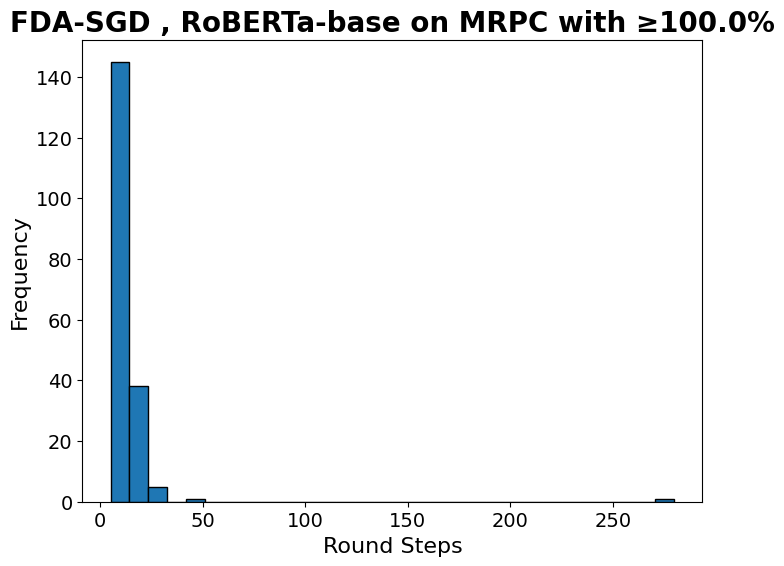

In [193]:
df = read_data('FDA-SGD', reported_f1, 1.)
steps_dist(df, 'FDA-SGD', 1.)

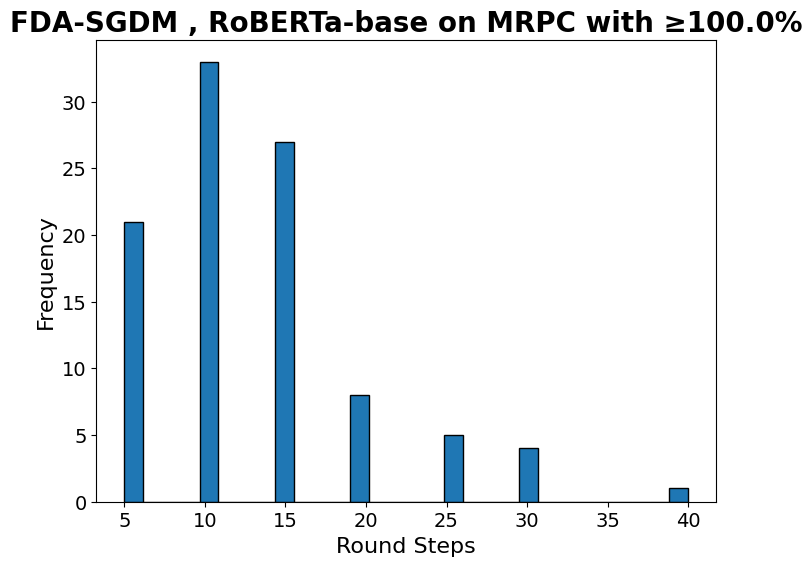

In [194]:
df = read_data('FDA-SGDM', reported_f1, 1.)
steps_dist(df, 'FDA-SGDM', 1.)